# Understand Transfer Learning and Finetuning with BERT


In [1]:
!pip install -U datasets

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, BertModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [4]:
from datasets import load_dataset, ClassLabel

# Load original dataset
dataset = load_dataset("emotion", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
from datasets import ClassLabel

# Step 1: Filter only desired labels (0-sadness, 1-joy, 3-anger)
dataset = dataset.filter(lambda x: x["label"] in [0, 1, 3])

# Step 2: Remap labels to 0,1,2
label_map = {0: 0, 1: 1, 3: 2}
dataset = dataset.map(lambda x: {"label": label_map[x["label"]]})

# Step 3: Properly update label class names using ClassLabel
new_label_feature = ClassLabel(num_classes=3, names=["sadness", "joy", "anger"])
dataset = dataset.cast_column("label", new_label_feature)

# Verify
print(dataset.features["label"].names)


Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12187 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12187 [00:00<?, ? examples/s]

['sadness', 'joy', 'anger']


In [8]:
dataset = dataset.train_test_split(test_size=0.2)

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9749
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2438
    })
})

In [10]:
train_texts = dataset['train']['text']

In [11]:
print(train_texts)

Column(['i feel irritable and unfulfilled if i dont paint for several days', 'i hate when im refered to that game guitar hero i mean its cool but i got the name kinda before lol and now i feel bitchy so stay the fuck outta my way', 'i feel it is worthwhile to document it for people who are not familiar with batch files', 'i had friends being sad feeling rejected from the world i think i finally realize that friends arent what i thought they were', 'im feeling discontent with everything and its manifesting itself in destructive self sabotaging ways'])


In [12]:
print(len(train_texts))

9749


In [13]:
train_labels = dataset['train' ]['label' ]

In [14]:
train_labels

Column([2, 2, 1, 0, 0])

In [15]:
print(len(train_labels))

9749


In [16]:
val_texts = dataset['test']['text']
val_labels = dataset['test']['label']

print(len(val_texts))
print(len(val_labels))

2438
2438


## we can finetune the bert for Text Classification, Named Entity Recognition (NER), Question and Answering

## Translation,Text Summarization(BART, T5)

### bert is not well suited for above task

In [17]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')

In [19]:
dataset = dataset.map(lambda x: tokenizer(x['text'], padding="max_length", truncation=True), batched=True)

Map:   0%|          | 0/9749 [00:00<?, ? examples/s]

Map:   0%|          | 0/2438 [00:00<?, ? examples/s]

In [20]:
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

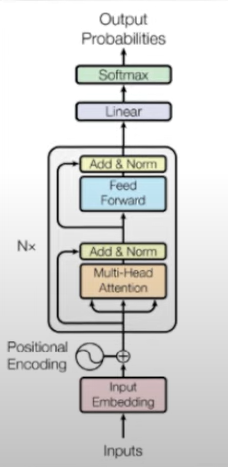

In [21]:
# Loap pre-trained model with new output head
model = BertForSequenceClassification.from_pretrained(
  "bert-base-uncased"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


These are the 12 Transformer blocks of BERT. Each layer contains:

1. Self-Attention module

2. Intermediate dense layer (like hidden expansion)

3. Output dense + LayerNorm

In [22]:
for name, param in model.named_parameters():
    print(f"{name:50} | Shape: {tuple(param.shape)} | Trainable: {param.requires_grad}")

bert.embeddings.word_embeddings.weight             | Shape: (30522, 768) | Trainable: True
bert.embeddings.position_embeddings.weight         | Shape: (512, 768) | Trainable: True
bert.embeddings.token_type_embeddings.weight       | Shape: (2, 768) | Trainable: True
bert.embeddings.LayerNorm.weight                   | Shape: (768,) | Trainable: True
bert.embeddings.LayerNorm.bias                     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.query.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.query.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.key.weight     | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.key.bias       | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.value.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.value.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.output.den

In [26]:
model_for_cls = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3 # For binary classification
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
for name, param in model_for_cls.named_parameters():
   print(f"{name:50} | Shape: {tuple(param.shape)} | Trainable: {param.requires_grad}")

bert.embeddings.word_embeddings.weight             | Shape: (30522, 768) | Trainable: True
bert.embeddings.position_embeddings.weight         | Shape: (512, 768) | Trainable: True
bert.embeddings.token_type_embeddings.weight       | Shape: (2, 768) | Trainable: True
bert.embeddings.LayerNorm.weight                   | Shape: (768,) | Trainable: True
bert.embeddings.LayerNorm.bias                     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.query.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.query.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.key.weight     | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.key.bias       | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.self.value.weight   | Shape: (768, 768) | Trainable: True
bert.encoder.layer.0.attention.self.value.bias     | Shape: (768,) | Trainable: True
bert.encoder.layer.0.attention.output.den

In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 109483778


In [31]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 109483778


In [32]:
print(model_for_cls.bert.embeddings)

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [33]:
print(model_for_cls.bert.encoder.layer[11])

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [34]:
print(model_for_cls.classifier)

Linear(in_features=768, out_features=3, bias=True)


In [36]:
print(model_for_cls.config) # Model config: hidden size, num labels, dropout, etc.

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.55.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [37]:
# Training args
training_args = TrainingArguments(
    output_dir="l/bert_output_1",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs",
    report_to="none"

)

In [40]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Trainer
trainer = Trainer(
    model=model_for_cls,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)


In [41]:
trainer.train()

Step,Training Loss
500,0.395700
1000,0.133200


TrainOutput(global_step=1219, training_loss=0.23124878518008324, metrics={'train_runtime': 894.7286, 'train_samples_per_second': 10.896, 'train_steps_per_second': 1.362, 'total_flos': 2565092709430272.0, 'train_loss': 0.23124878518008324, 'epoch': 1.0})

## unfreeze couple of last layer then train it

In [42]:
from transformers import BertModel, BertTokenizer, PreTrainedModel, Trainer, TrainingArguments, BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput

In [43]:
bert = BertModel.from_pretrained("bert-base-uncased")

In [44]:
for param in bert.parameters():
    #print(param)
    param.requires_grad = False

In [45]:
bert.encoder

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [46]:
bert.encoder.layer

ModuleList(
  (0-11): 12 x BertLayer(
    (attention): BertAttention(
      (self): BertSdpaSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [47]:
# for layer in bert.encoder.layer[-2:]
for layer in bert.encoder.layer:
    print(layer)

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
 

In [50]:
# Unfreeze layers from encoder layer 2 onward
for layer in bert.encoder.layer[2:]:
    for param in layer.parameters():
        param.requires_grad = True
        # print(param)  # Uncomment if you want to see the parameter tensors


In [52]:
import torch
import torch.nn as nn
from transformers import BertModel, PreTrainedModel, BertConfig

class BertMultiClassClassifier(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Classifier layer for 3 classes
        self.classifier = nn.Linear(config.hidden_size, 3)

        # Freeze all BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last 2 encoder layers
        for layer in self.bert.encoder.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Unfreeze the pooler
        for param in self.bert.pooler.parameters():
            param.requires_grad = True

        # Classifier should be trainable
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Get logits
        logits = self.classifier(pooled_output)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        # Return in transformers-style dictionary
        return {
            "loss": loss,
            "logits": logits
        }


In [62]:
import torch
import torch.nn as nn
from transformers import BertModel, PreTrainedModel, BertConfig

class BertMultiClassClassifier(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Classifier layer for 3 classes
        self.classifier = nn.Linear(config.hidden_size, 3)

        # Freeze all BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last 2 encoder layers
        for layer in self.bert.encoder.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Unfreeze the pooler
        for param in self.bert.pooler.parameters():
            param.requires_grad = True

        # Classifier should be trainable
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        # Pass everything into BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids   # <-- FIXED
        )
        pooled_output = outputs.pooler_output

        # Classifier
        logits = self.classifier(pooled_output)

        # Compute loss if labels exist
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


In [63]:
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)

In [64]:
model = BertMultiClassClassifier(config)

In [65]:
training_args = TrainingArguments(
    output_dir="./bert_last2layers_finetune",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="no",
    report_to="none", # Disable wandb etc.
    logging_dir="./logs"
)

In [66]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

trainer.train()

Step,Training Loss
500,0.609900
1000,0.362800


TrainOutput(global_step=1219, training_loss=0.4563262163370334, metrics={'train_runtime': 375.543, 'train_samples_per_second': 25.96, 'train_steps_per_second': 3.246, 'total_flos': 2565092709430272.0, 'train_loss': 0.4563262163370334, 'epoch': 1.0})

In [68]:
label_names = ["sadness", "joy", "anger"]

def predict_text(text, model, tokenizer):
    device = next(model.parameters()).device   # get model device (cpu or cuda)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)   # <-- move inputs to same device as model

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs["logits"]

        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1)[0][predicted_class].item()
        label_name = label_names[predicted_class]

        print(f"Text: {text}")
        print(f"Prediction: {label_name} (Confidence: {confidence:.2f})")

        return label_name, confidence


In [69]:
predict_text("I'm feeling really happy today!", model, tokenizer)
predict_text("I just want to cry and sleep.", model, tokenizer)


Text: I'm feeling really happy today!
Prediction: joy (Confidence: 1.00)
Text: I just want to cry and sleep.
Prediction: sadness (Confidence: 0.93)


('sadness', 0.9258754849433899)